Final NTFF implementation given update eqns

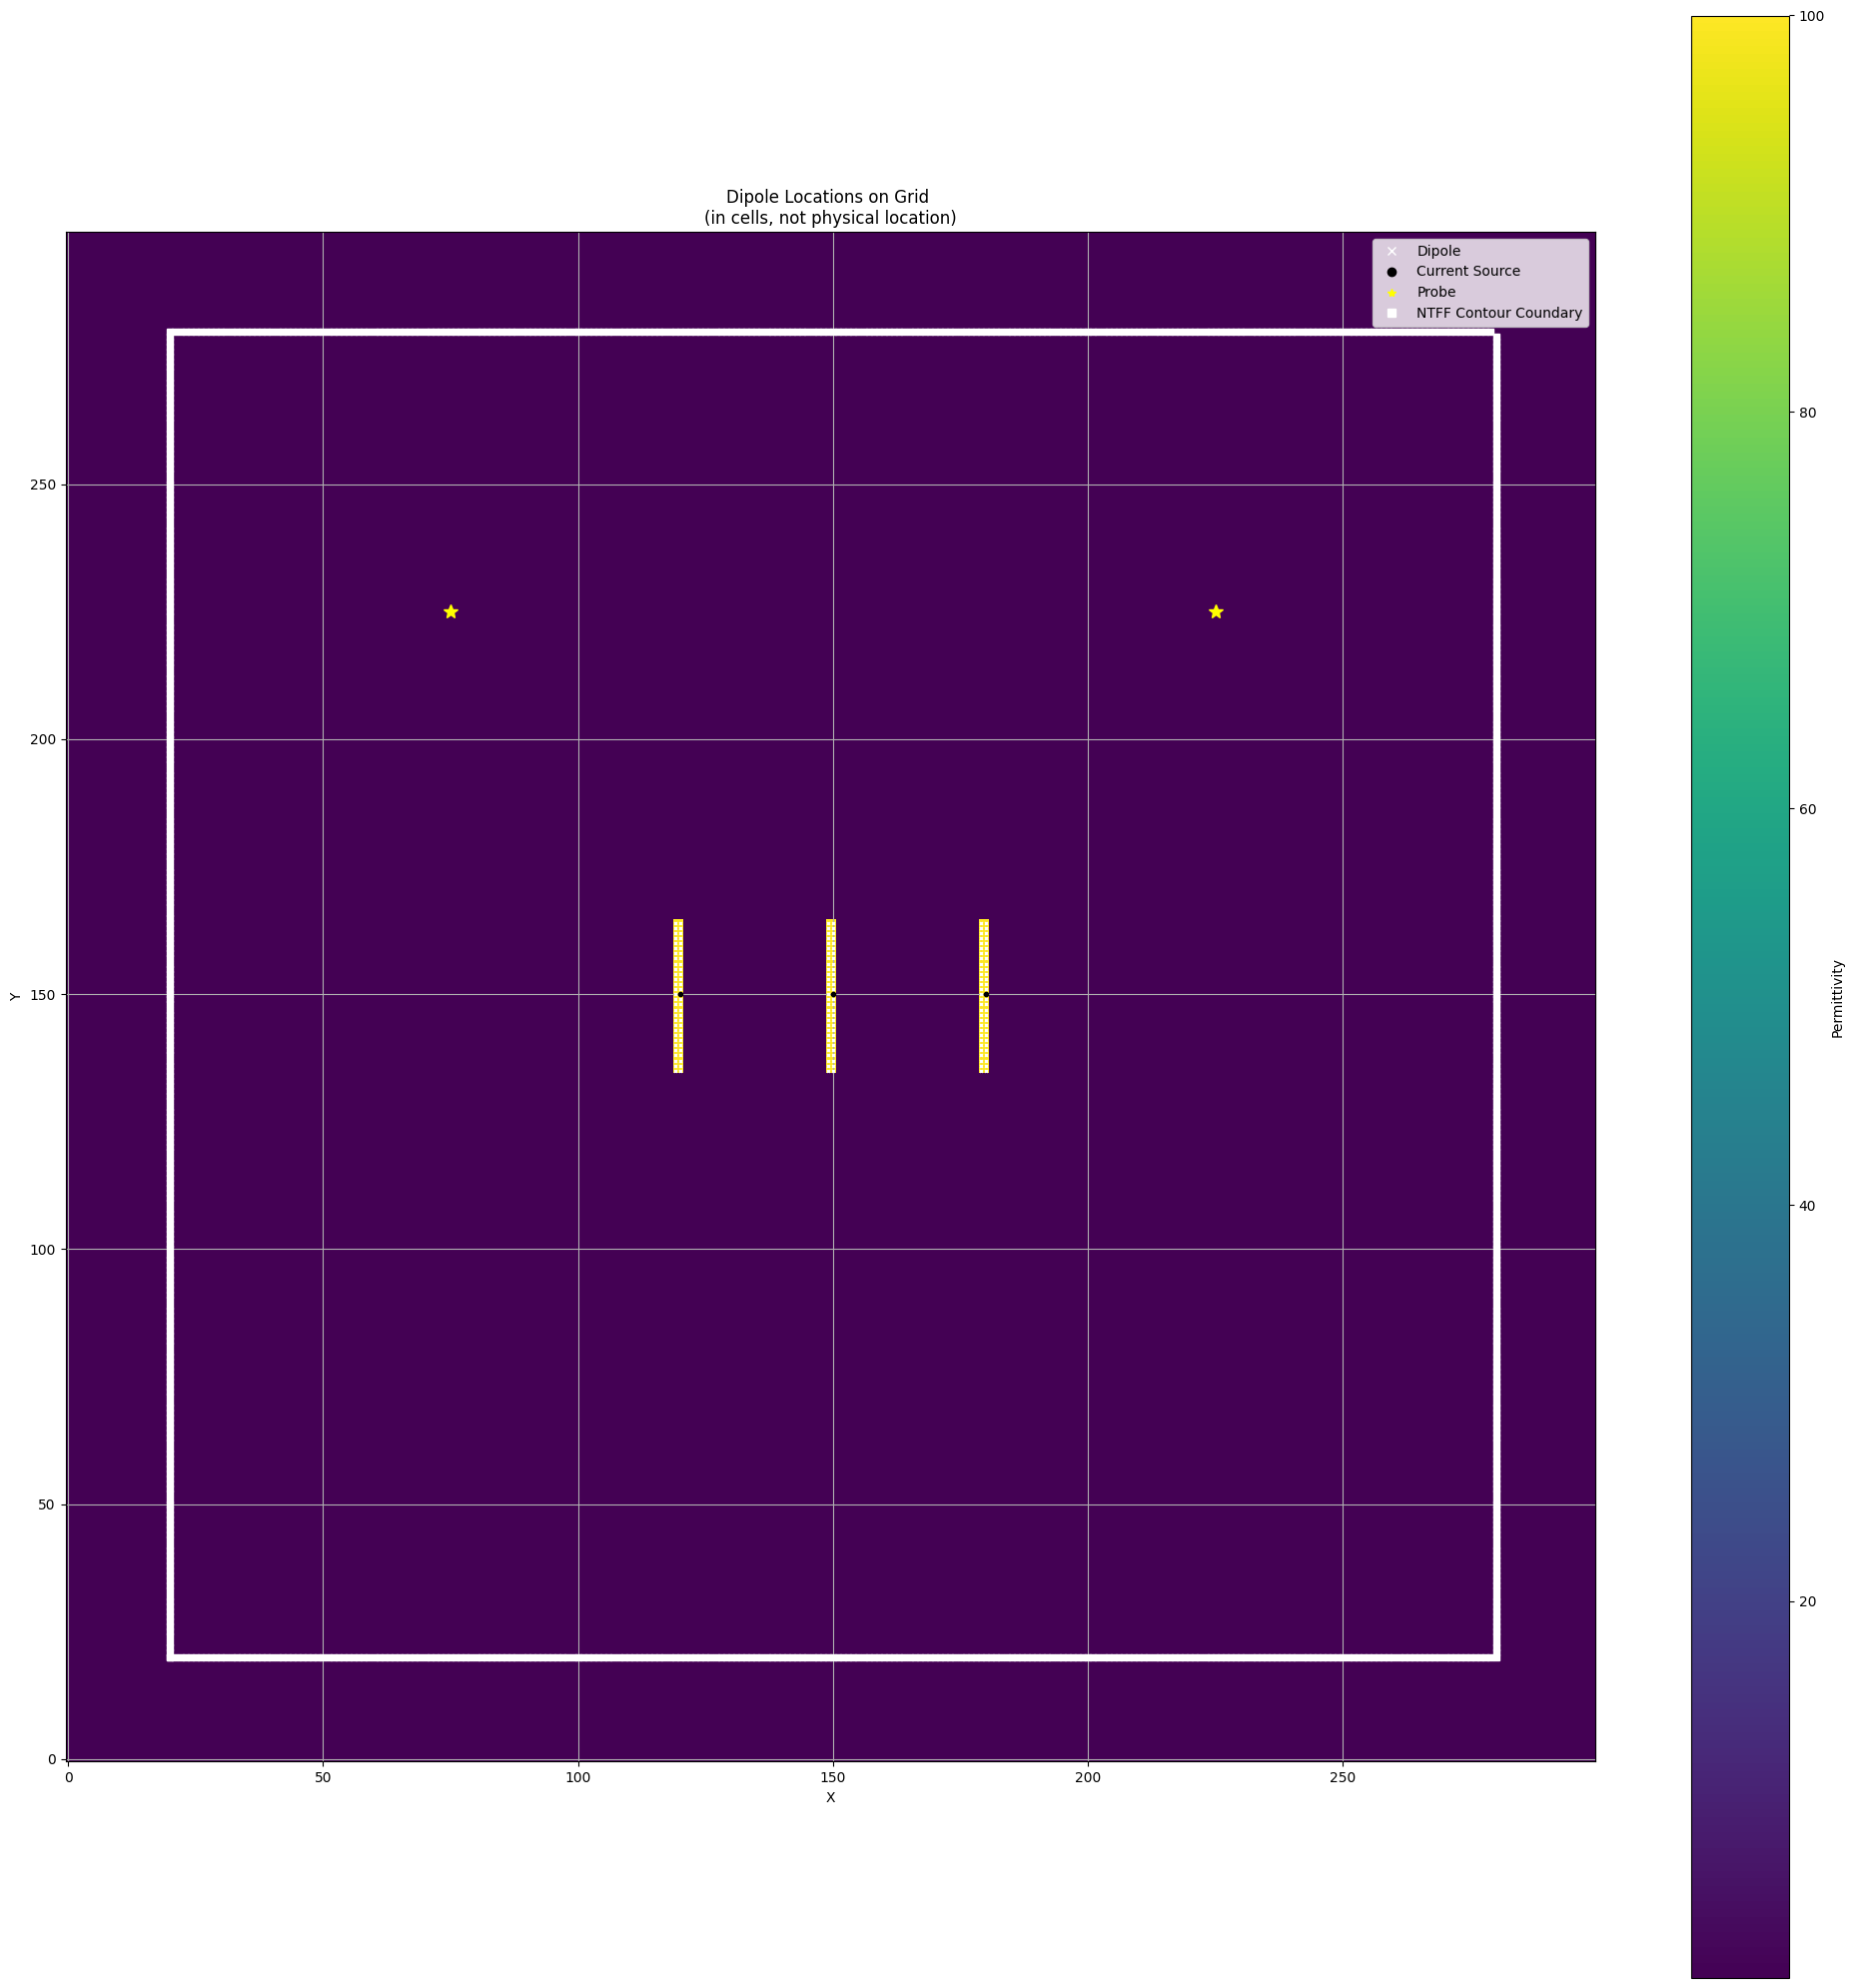

120 150 -0.0
150 150 -333216220.36187744
180 150 -666432440.7237549


In [ ]:
# streamlined function to simulate 1xn antennas

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

# Simulation Parameters
e0 = 1        
mu0 = 1       
c0 = 1 #1 / math.sqrt(e0 * mu0) 
dx = 0.5e-3 # unit cell is 0.5mm x 0.5mm
dy = 0.5e-3 
magic_time_step = dx / (np.sqrt(2) * c0)
max_time_steps = 520
#max_time_steps = 250
f0 = 5e9

# Grid in cell units
whole_grid = 150e-3 # whole grid = 200 mm
numX_cells = int(whole_grid / dx)  
numY_cells = int(whole_grid / dy)   
center_x = numX_cells // 2 # find center points
center_y = numY_cells // 2

# Set up the permittivity grid 
grid = np.ones((numY_cells, numX_cells)) * e0

# Source parameters
lambda0 = c0/f0 # wavelength for 5G is 6 cm
lambda_lower = c0 / 4.5e-9
lambda_upper = c0 / 5.5e-9
omega0 = 2 * np.pi * c0 / lambda0
sigma = (2 / omega0) * (lambda0 / (lambda_upper - lambda_lower))

# Arrays to store fields
Ez = np.zeros((numX_cells, numY_cells))
Hx = np.zeros((numX_cells, numY_cells))
Hy = np.zeros((numX_cells, numY_cells))

# Dipole Parameters
numberAntennas = 3
dipole_epsilon = 100
dipole_spacing_cells = int(15e-3 / dx) # space between dipoles = 15mm = 30 cells
dipole_width = 1e-3 # dipole thickness = 1 mm
dipole_height = 15e-3 # dipole height = 15 mm
dipole_width_cells = int(dipole_width / dx)         
dipole_height_cells = int(dipole_height / dy)  

# Probe locations
probe_beam_direction_x = int(numX_cells *.75) # this probe is put at the angle of target beam (45 degrees from x axis)
probe_beam_direction_y = int(numY_cells * .75)
probe_x = int(numX_cells * .25) # this probe is put far away from target angle (135 from x axis)
probe_y = int(numY_cells *.75)
Ez_probe_beam = np.zeros(max_time_steps) # store values at probes
Ez_probe = np.zeros(max_time_steps)

# NTFF Parameters ----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Compute phasor E and M fields on closed contour boundary
# defining square boundary form L1 --> L4
line_size = whole_grid - 20e-3 # lines form a boundary 10mm inside of whole grid size
numL_cells = int(line_size // dx) #numL cells is length of closed countour boundary in cell units

L_starting_dim= 10e-3 #starting index for L2, L4
L_starting_cell_idx = int(L_starting_dim //dx)
L_ending_dim= numX_cells - numL_cells
L_ending_cell_idx=L_starting_cell_idx + numL_cells

#L1 is vertical, RHS line
L1_col1 = np.full(numL_cells, L_ending_cell_idx)
L1_col2=np.arange(L_starting_cell_idx, L_ending_cell_idx)

L1_idxs = np.column_stack((L1_col1,L1_col2))

#L2 is vertical, LHS line
L2_col1=np.full(numL_cells,L_starting_cell_idx)
L2_col2=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L2_idxs=np.column_stack((L2_col1,L2_col2))

#L3 is horizontal, top line
L3_col1=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L3_col2=np.full(numL_cells, L_ending_cell_idx)
L3_idxs=np.column_stack((L3_col1,L3_col2))

#L4 is horizontal, bottom line
L4_col1=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L4_col2=np.full(numL_cells, L_starting_cell_idx)
L4_idxs=np.column_stack((L4_col1,L4_col2))

#print(L1_idxs)
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Current source vectors
sources = []

# Beam steering parameters
angle_target = 45
angle_target_rad = np.deg2rad(angle_target)
# k0 = 2 * np.pi / lambda0

# Store Ez Frames
Ez_frames = []

def placeAndVisualizeAntennas(numAntennas, spacingBetween, dipoleLength, dipoleWidth, grid, e_dipole):

    # find where the centers of each dipole would be
    centers = []

    if (numAntennas %2) == 1: # for odd number of antennas, the middle one is at center of grid
        for i in range(numAntennas):
            leftPoint = center_x - (numAntennas //2) *spacingBetween
            centers.append(leftPoint + (i*spacingBetween))

    else: # for an even number of antennas, the middle point of grid is between two antennas
        spaceFromCenter = spacingBetween // 2
        for i in range(numAntennas):
            leftPoint = center_x - (numAntennas //2 -1) *spacingBetween - spaceFromCenter
            centers.append(leftPoint + (i*spacingBetween))

    # Visualize everything
    plt.figure(figsize=(20, 20))

    # Find dimensions of antenna on the grid
    for x in centers:
        x_center = x
        x_left = x_center - (dipoleWidth // 2)
        x_right = x_left + dipoleWidth - 1
        x_bottom = center_y - (dipoleLength // 2)
        x_top = x_bottom + dipoleLength - 1

        # place antennas on permittivity grid
        for y in range(x_left, x_right + 1):
            for z in range(x_bottom, x_top + 1):
                grid[z, y] = e_dipole
                plt.plot(y, z, 'x', markersize = 2, color='white')

        sources.append((x, center_y))
    
    # Show where the sources are injected on grid
    for location in sources:
        plt.plot(location[0], location[1], 'o', markersize = 3, color = 'black')
    
    # Show where the probes are on the grid
    plt.plot(probe_beam_direction_x, probe_beam_direction_y, '*', markersize = 10, color = 'yellow')
    plt.plot(probe_x, probe_y, '*', markersize = 10, color = 'yellow')

    #Adding (x,y) pairs from L1, shown as white
    all_line_idx=[L1_idxs,L2_idxs,L3_idxs,L4_idxs]
    for j in all_line_idx:
        for x, y in j:
            plt.plot(x,y, 's',markersize = 4, color = 'white')
    
    # Plot the permittivity grid
    plt.imshow(grid, cmap='viridis', origin= 'lower')
    plt.colorbar(label='Permittivity')

    # Add the legend
    plt.plot([], [], 'x', color = 'white', label = 'Dipole')
    plt.plot([], [], 'o', color = 'black', label = 'Current Source')
    plt.plot([], [], '*', color = 'yellow', label = 'Probe')
    plt.plot([], [], 's', color ='white', label = 'NTFF Contour Coundary')
    plt.legend(loc='upper right', fontsize = 'medium')

    plt.title('Dipole Locations on Grid \n(in cells, not physical location)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    plt.grid()
    plt.show()

placeAndVisualizeAntennas(numberAntennas, dipole_spacing_cells, dipole_height_cells, dipole_width_cells, grid, dipole_epsilon)
k0 = 2*np.pi/lambda0
for idx, (x_coord, y_coord) in enumerate(sources):
    phase = -k0*dipole_spacing_cells*dx * idx * np.cos(angle_target_rad)
    print(x_coord, y_coord, phase)

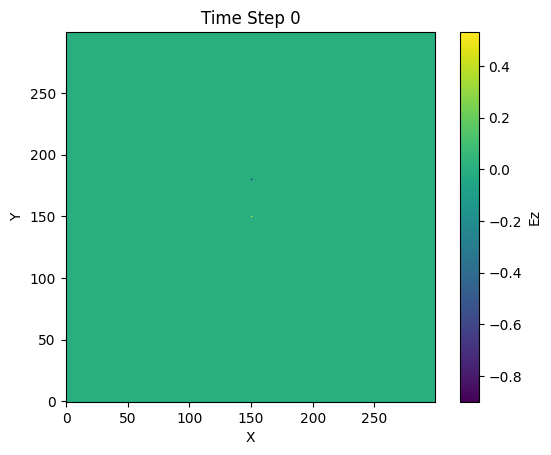

Reached time  0
Reached time  10
Reached time  20
Reached time  30
Reached time  40


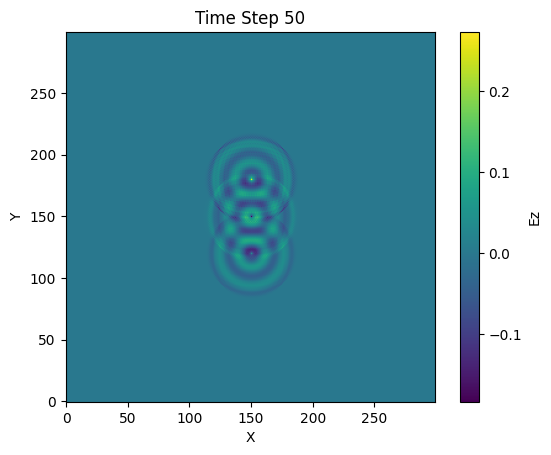

Reached time  50
Reached time  60


KeyboardInterrupt: 

In [9]:
# TESTING ONLY
# Running FDTD for testing purposes only
# 2D FDTD Model

# Using absorbing boundary condition to simulate the energy being absorbed in air.
boundaryLeft = np.zeros(numY_cells)
boundaryRight = np.zeros(numY_cells)
boundaryBottom = np.zeros(numX_cells)
boundaryTop = np.zeros(numX_cells)

#defining Ez_time_L1
Ez_time_L1 = np.zeros((numL_cells, max_time_steps))
Hx_time_L1 = np.zeros((numL_cells, max_time_steps))
Hy_time_L1 = np.zeros((numL_cells, max_time_steps))

#defining L2
Ez_time_L2 = np.zeros((numL_cells, max_time_steps))
Hx_time_L2 = np.zeros((numL_cells, max_time_steps))
Hy_time_L2 = np.zeros((numL_cells, max_time_steps))

#defining L3
Ez_time_L3 = np.zeros((numL_cells, max_time_steps))
Hx_time_L3 = np.zeros((numL_cells, max_time_steps))
Hy_time_L3 = np.zeros((numL_cells, max_time_steps))

#defining L4
Ez_time_L4 = np.zeros((numL_cells, max_time_steps))
Hx_time_L4 = np.zeros((numL_cells, max_time_steps))
Hy_time_L4 = np.zeros((numL_cells, max_time_steps))

#combining time domain into lists
L_idxs_list = [L1_idxs, L2_idxs, L3_idxs, L4_idxs]
Ez_time_list = [Ez_time_L1, Ez_time_L2, Ez_time_L3, Ez_time_L4]
Hx_time_list = [Hx_time_L1, Hx_time_L2, Hx_time_L3, Hx_time_L4]
Hy_time_list = [Hy_time_L1, Hy_time_L2, Hy_time_L3, Hy_time_L4]

# Main 2D FDTD Loop
for n in range(max_time_steps):

    # Compute Hy 
    for i in range(numX_cells - 1):
        for j in range(numY_cells):
            Hy[i, j] += (Ez[i + 1, j] - Ez[i, j]) * magic_time_step / dx
            for k in range(4):
                match = np.any((L_idxs_list[k][:, 0] == i) & (L_idxs_list[k][:, 1] == j))
                if match:
                    idx = np.where((L_idxs_list[k][:, 0] == i) & (L_idxs_list[k][:, 1] == j))[0]
                    Hy_time_list[k][idx, n] = Hy[i, j]



     # Compute Hx
    for i in range(numX_cells):
        for j in range(numY_cells - 1):
            Hx[i, j] -= (Ez[i, j + 1] - Ez[i, j]) * magic_time_step / dy
            for k in range(4):
                match = np.any((L_idxs_list[k][:, 0] == i) & (L_idxs_list[k][:, 1] == j))
                if match:
                    idx = np.where((L_idxs_list[k][:, 0] == i) & (L_idxs_list[k][:, 1] == j))[0]
                    Hx_time_list[k][idx, n] = Hx[i, j]


    # Use temp variables to store left and bottom Ez values sorta like a moving window; only 2 sides needed bc symmetrical
    tempLeft = Ez[1, :].copy() 
    tempBottom = Ez[:, 1].copy()  

    # Compute Ez
    for i in range(1, numX_cells - 1):
        for j in range(1, numY_cells - 1):
            Ez[i, j] += ((Hy[i, j] - Hy[i - 1, j]) * magic_time_step / dx) - ((Hx[i, j] - Hx[i, j - 1]) * magic_time_step / dy)

            #recording Ez at L1
            for k in range(4):
                match = np.any((L_idxs_list[k][:, 0] == i) & (L_idxs_list[k][:, 1] == j))
                if match:
                    idx = np.where((L_idxs_list[k][:, 0] == i) & (L_idxs_list[k][:, 1] == j))[0]
                    Ez_time_list[k][idx, n] = Ez[i, j]


            
     # Store Ez at probes
    Ez_probe_beam[n] = np.abs(Ez[probe_beam_direction_x, probe_beam_direction_y])
    Ez_probe[n] = np.abs(Ez[probe_x, probe_y])

    # Apply excitation at antenna sources
    t_n = n * magic_time_step
    for idx, (x_coord, y_coord) in enumerate(sources):
        phase = -k0*dipole_spacing_cells*dx * idx * np.cos(angle_target_rad)
        # Ez[x_coord, y_coord] += np.exp(-((t_n - 4 * sigma) ** 2) / sigma ** 2) * np.sin(omega0 * t_n + phase)
        Ez[x_coord, y_coord] += np.sin(omega0 * t_n + phase)

    # Update PEC conditions
    Ez[0, :] = boundaryLeft
    Ez[-1, :] = boundaryRight
    Ez[:, 0] = boundaryBottom
    Ez[:, -1] = boundaryTop

    # Update boundary buffers for next time step
    boundaryLeft = tempLeft
    boundaryBottom = tempBottom
    boundaryRight = Ez[-2, :].copy()
    boundaryTop   = Ez[:, -2].copy()
    
    # Visualize Ez field every 50 time steps
    if n % 50 == 0:
        plt.clf() 
        plt.imshow(Ez, cmap='viridis', origin='lower')
        plt.title(f"Time Step {n}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.colorbar(label="Ez")
        plt.pause(0.01) 
        plt.show()
        # Create Ez animation using frames at every 10 time steps 
    if n % 10 == 0:
        Ez_frames.append(Ez.copy())
        print("Reached time ", n)

#print(Ez_time_L1)
plt.show()

IndexError: list index out of range

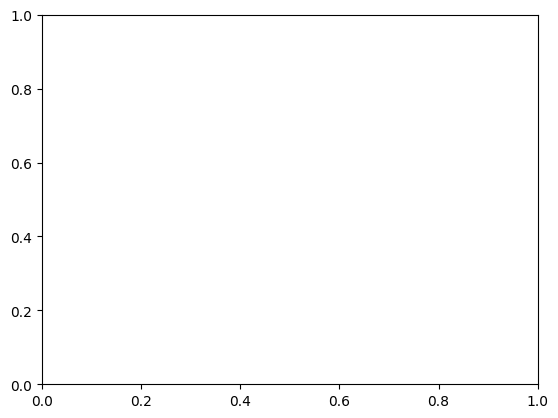

In [6]:
# Create animation
from IPython.display import HTML  # Required to embed the animation
import matplotlib.animation as animation

fig, ax = plt.subplots()
cax = ax.imshow(Ez_frames[0], cmap='viridis', origin='lower')
fig.colorbar(cax, label="Ez")
title = ax.set_title("")

def update(frame_idx):
    cax.set_array(Ez_frames[frame_idx])
    title.set_text(f"Time Step {frame_idx * 10}")
    return cax, title

ani = animation.FuncAnimation(fig, update, frames=len(Ez_frames), interval=100, blit=False)
HTML(ani.to_jshtml())


In [ ]:
# Plot Ez at the probe in direction of beam over time in comparison to probe at opposite direction
time_steps = np.arange(max_time_steps)*magic_time_step
plt.semilogy(time_steps, Ez_probe_beam, label='Ez at probe in direction of beam', color = 'red')
plt.semilogy(time_steps, Ez_probe, label='Ez at probe in opposite direction of beam', color = 'blue')
plt.xlabel('Time (s)')
plt.ylabel('|Ez| (log scale)')
plt.title('|Ez| at Probes Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Performing FFT along closed contours
Ez_t_list = [Ez_time_L1, Ez_time_L2, Ez_time_L3, Ez_time_L4]

Ez_fft_vals = [np.fft.fft(Ez_time, axis=1) for Ez_time in Ez_t_list]
Ez_freqs = [np.fft.fftfreq(max_time_steps, d=magic_time_step) for _ in Ez_t_list]


Hx_t_list = [Hx_time_L1, Hx_time_L2, Hx_time_L3, Hx_time_L4]

Hx_fft_vals = [np.fft.fft(Hx_time, axis=1) for Hx_time in Hx_t_list]
Hx_freqs = [np.fft.fftfreq(max_time_steps, d=magic_time_step) for _ in Hx_t_list]


Hy_t_list = [Hy_time_L1, Hy_time_L2, Hy_time_L3, Hy_time_L4]

Hy_fft_vals = [np.fft.fft(Hy_time, axis=1) for Hy_time in Hy_t_list]
Hy_freqs = [np.fft.fftfreq(max_time_steps, d=magic_time_step) for _ in Hy_t_list]


peak_freq_val=16.970562748477143

In [ ]:
#Computing equivalent J and M current densities
for freqs_arr in Ez_freqs:

    target_freq= omega0/(2*np.pi)
    bin_idx = np.argmin(np.abs(freqs_arr - target_freq))
    print('Bin index is ',bin_idx)


Meq_L1_phasors = Ez_fft_vals[0][:,bin_idx]
Meq_L2_phasors = -Ez_fft_vals[1][:,bin_idx]
Meq_L3_phasors = -Ez_fft_vals[2][:,bin_idx]
Meq_L4_phasors= Ez_fft_vals[3][:,bin_idx]

Jeq_L1_phasors=Hy_fft_vals[0][:,bin_idx]
Jeq_L2_phasors=-Hy_fft_vals[1][:,bin_idx]
Jeq_L3_phasors=-Hx_fft_vals[2][:,bin_idx]
Jeq_L4_phasors=Hx_fft_vals[3][:,bin_idx]

#creating list for all Jeq and Meq components along grid
Meq_phasors=[Meq_L1_phasors,Meq_L2_phasors,Meq_L3_phasors,Meq_L4_phasors]
Jeq_phasors=[Jeq_L1_phasors,Jeq_L2_phasors,Jeq_L3_phasors,Jeq_L4_phasors]

In [ ]:
#Computing r' cos (phi) for each exponential factor in scattering width eqn

#Nested loop to compute each individual line integral component, for each theta

#Computing scattering width for each theta component

theta_input_param=np.linspace(1,360,360)
r_prime_cos_phi_vec=[]
sigma_2d=np.zeros(360)

#replace lambda0 with lambda
lambda_new=c0/peak_freq_val
k = 2 * np.pi / lambda_new
E_initial_amplitude = 1
for theta in theta_input_param:
    theta_deg = theta
    r_prime_cos_phi_vec_L1=[]
    r_prime_vec_L1=[]
    phi_vector_L1=[]

    theta_rad=math.radians(theta_deg)
    r_mag_L1=((L_ending_cell_idx-center_x)*dx) / math.cos(theta_rad)
    for x, y in L1_idxs:
        x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
        r_prime_mag=np.linalg.norm(x_y_distances)
        
        theta_prime_rad = math.asin ( ((y-center_y)*dy) / r_prime_mag)
        theta_prime_deg=math.degrees(theta_prime_rad)
        phi=theta_deg-theta_prime_deg

        phi_rad=math.radians(phi)
        phi_vector_L1.append(phi)

        phase_const= r_mag_L1 * math.cos(phi_rad)

        r_prime_cos_phi_vec_L1.append(phase_const)
    
    r_prime_cos_phi_vec_L2=[]
    r_prime_vec_L2=[]
    phi_vector_L2=[]
    r_mag_L2=abs(((L_starting_cell_idx-center_x)*dx)) / math.cos(theta_rad)

    for x, y in L2_idxs:
        x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
        r_prime_mag=abs(np.linalg.norm(x_y_distances))
        
        theta_prime_rad = math.asin ( ((y-center_y)*dy) / r_prime_mag)
        theta_prime_deg=math.degrees(theta_prime_rad)
        phi=-((theta_deg-180)-theta_prime_deg)

        phi_rad=math.radians(phi)
        phi_vector_L2.append(phi)

        phase_const= r_mag_L2 * math.cos(phi_rad)

        r_prime_cos_phi_vec_L2.append(phase_const)

    r_prime_cos_phi_vec_L3=[]
    r_prime_vec_L3=[]
    phi_vector_L3=[]
    r_mag_L3=abs(((L_ending_cell_idx-center_y*dy) / math.sin(theta_rad)))

    for x, y in L3_idxs:
        x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
        r_prime_mag=abs(np.linalg.norm(x_y_distances))
        
        theta_prime_rad = math.acos ( ((x-center_x)*dx) / r_prime_mag)
        theta_prime_deg=math.degrees(theta_prime_rad)
        phi=(180-theta_deg)-theta_prime_deg

        phi_rad=math.radians(phi)
        phi_vector_L3.append(phi)

        phase_const= r_mag_L3 * math.cos(phi_rad)

        r_prime_cos_phi_vec_L3.append(phase_const)

   
    r_prime_cos_phi_vec_L4=[]
    r_prime_vec_L4=[]
    phi_vector_L4=[]
    r_mag_L4=abs(((L_starting_cell_idx-center_y*dy) / math.sin(theta_rad)))

    for x, y in L4_idxs:
        x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
        r_prime_mag=abs(np.linalg.norm(x_y_distances))
        
        theta_prime_rad = math.acos ( ((x-center_x)*dx) / r_prime_mag)
        theta_prime_deg=math.degrees(theta_prime_rad)
        phi=-((theta_deg-180)-theta_prime_deg)

        phi_rad=math.radians(phi)
        phi_vector_L4.append(phi)

        phase_const= r_mag_L4 * math.cos(phi_rad)

        r_prime_cos_phi_vec_L4.append(phase_const)

    r_cos_factors=[r_prime_cos_phi_vec_L1,r_prime_cos_phi_vec_L2,r_prime_cos_phi_vec_L3,r_prime_cos_phi_vec_L4]
    r_cos_factors=np.array(r_cos_factors)

#want to check if getting same plot when only considering L1
    #L_integral_arr=[ ((omega0*mu0*np.sum(Jeq[0:-1])) - (k*Meq[0:-1]))*np.exp(1j*k*r_cos[0:-1])
                #for Jeq, Meq, r_cos in zip(Jeq_phasors,Meq_phasors, r_cos_factors)]
    L_integral_arr= ((omega0*mu0*np.sum(Jeq_phasors[2][0:-1])) - (k*Meq_phasors[2][0:-1]))*np.exp(1j*k*r_cos_factors[2][0:-1])
                #for Jeq, Meq, r_cos in zip(Jeq_phasors,Meq_phasors, r_cos_factors)]
   
    #L_integral_vals=[ (np.sum(contour_val)) for contour_val in L_integral_arr]
    L_integral_vals= (np.sum(contour_val) for contour_val in L_integral_arr)

    L_integral_final=(abs(np.sum(L_integral_vals)))**2
    sigma_2d[int(theta) - 1]=(lambda_new / (8*np.pi*(E_initial_amplitude**2))) * L_integral_final



In [ ]:
#Plotting Scattering width

 
plt.figure()
plt.plot(theta_input_param, sigma_2d)
plt.xlabel('Theta (degrees)')
plt.ylabel('Scattering width')
plt.title('NTFF for given theta')
plt.show()